### Contents
0. [Foreword](#Foreword)
1. [Introduction](#Introduction)
    1. [Intro to VSM's](#Intro-to-Vector-Space-Models)
    1. [Linguistic Motivation](#Linguistic-Motivation)
    1. [Counts & Context Windows](#Counts-&-Context-Windows)
1. [Initial Exploration](#Initial-Exploration)
    1. [Corpus](#Corpus)
    1. [Semantics](#Words-as-Concepts)
        1. [Noise obscures meaningful comparisons](#Noise-obscures-meaningful-comparisons)
    1. [Visualizing word embeddings](#Visualizing-word-embeddings)
        1. [Age](#Age)
        1.[Trio](#Trio)
    1. [Quantitative Evaluation](#Quantitative-Evaluation)
     
   



In [1]:
import pandas as pd #imports
import numpy as np
import os 
import utils# general utility functions
import vsm # utils for vector space model needs
import random
from scipy.stats import spearmanr
DATA_HOME = os.path.join('data/data', 'vsmdata') # vsm related data 
giga5 = pd.read_csv(
    os.path.join(DATA_HOME, 'giga_window5-scaled.csv.gz'), index_col=0) #other coprpuses include yelp_20 and giga_20
giga = giga5.iloc[11:,11:] # filters emoticons in output
W = giga5.iloc[12:,12:] # same
DATA_HOME2 = os.path.join('data/data', 'wordrelatedness') #data read-in
utils.fix_random_seeds()
eval_df = pd.read_csv(
    os.path.join(DATA_HOME2, "wordrelatedness-dev.csv")) # relatedness dataset for evaluation
def distance2pred(pred_df): # converts cosine distance to similarity
    lis = [-1*i for i in pred_df['prediction']]
    random_pred_df['prediction'] = pd.Series(lis)
    return pred_df
def random_scorer(x1, x2): # random guesses as a baseline
    return random.random()

### Foreword
Although I didn’t know it at the time, my Machine Learning journey began about a year and a half ago. Searching for a major (and life purpose), I took a survey course in Neuroscience. Inspired by Francis Crick’s own search for the soul in his book The Astonishing Hypothesis, I walked in with starry eyes and untempered ambition. It seems I was not alone. Before introducing the course or even himself, our professor methodically relieved us from the lofty goals we had for the field. Instead of solving conciousness, he directed our gaze to the basics. The simple act of remembering proved astonishing enough for me. Although I’ve since settled on a different field, learning and memory have become the throughline from which I view artificial intelligence. However, you won’t find any learning algorithms in these notebooks. After blindly throwing models of increasing complexity at some problems, I realized I still didn’t know the first thing about the datasets themselves. This, then, is an exercise on a few upstream elements of ML pipelines---exploratory analysis, dimensionality reductions, and visualizations. I hope you find some utility in it, and if not, that it at least serves as an interesting read.

# Introduction

##### Vector Space Models 
In many ways, the rise of Natural Language Processing (NLP) is a microcosm of ML’s own emergence. Big data and powerful processors allow previously known statistical techniques to reach their full potential.  Vector Space Models (VSMs) are good example of how powerful these ideas can be at scale. A fun introduction to VSMs is the word guessing game Semantle (https://semantle.novalis.org/). You’ll notice the more related your guess is to the hidden word, the better your score is. If you guess right, or in my case give up, you can click for the nearest words to the answer. There are always some oddities but for the most part the nearest neighbors are surprisingly meaningful. That is to say, they are semantically related.  In Semantle, and all Vector Space Models, each word is represented by a high dimensional vector whose components are also words. Since all vectors have the same dimensionality, we tend to call them embeddings. Imagine a VSM comprised of only four words : ‘cat’, ‘dog’, ‘apple’, and ‘blue’. A general embedding is shown, as well as mock embeddings for 'cat' and 'dog'^^. Since different words will have unique values for each component, they take on unique identities. All word embeddings, by definition though, share the same set of words they're defined through. Scrolling through the nearest neighbors on Semantle shows the components by which any word is judged. In short, the embeddings form a matrix of data, whose columns span a space we use to map words. This matrix (dataset) *is* the VSM. 


##### Linguistic Motivation
Consider the sentence “...many cattle farmers are going further into debt as grain prices increase.” Intuitively, we know ‘cattle’, ‘farmer’, and ‘grain’ probably group together more than ‘going’, ‘prices’, and ‘into’. Given just this sentence, an alien would be at a loss. However, if they could listen to every time the word ‘farmer’ was uttered across the globe for a week, they’d probably come to a similar conclusion. This is the essence of the distributional hypothesis. Summed up by linguist John Firth’s famous line, “You shall know a word by the company it keeps”, the idea that frequency distributions can give insight about usage is as fascinating as it is useful. Defining a notion of context and investigating the members present in that context tells us a little bit. Repeating this process over a huge corpus, say millions of news articles, tells us a lot. This is the ultimate source for the component values in all VSMs. 

#### Counts & Context Windows
Let’s keep the news articles example. What we define as context is up to us. It could be a sentence or even a paragraph. Perhaps there's value to keeping the scope  local though. It makes basic linguistic sense that the immediate neighbors of some target word are probably more relevant. For now, let’s just define context as the immediate two words left and right of a target(center) word. This is our window. Imagine the farmer sentence is the start of the corpus. We’d scan through it so each word gets to be a target. We look left and right, observe the present words and update.

 “**Many** *cattle* *farmers* are going further into debt as grain prices increase.” Window1
 
 Current neighbor words for **Many**: cattle 1, farmers 1
 
“*Many* **cattle** *farmers* *are* going further into debt as grain prices increase.” Window2

 Current neighbor words for: **Cattle**: many 1, farmers 1, are 1

“*Many* *cattle* **farmers** *are* *going* further into debt as grain prices increase.” Window3

 Current neighbor words for: **Farmers**: many 1, cattle 1, are 1, going 1

The edges of a corpus won’t have the full window but that’s ok.  To wrap it up, let’s imagine we’re at the end of the corpus. 

“… banned predatory credit card offers because it *encouraged* *unhealthy* **debt**.”  Window n

*Final* neighbor words for **Debt**: arrive 2, **poor** 45, my 5, underlying 6, … encouraged 3+1, unhealthy 7+1, … zealot 1

I’ve added +1 to relay the sense of those two words updating from previous counts. Notice that at this stage the center word, debt, has many unique neighbors with a range of values. In fact, each target word has values for the whole vocabulary. If a word was never a neighbor for a target it simply has a count of zero. This ensures all embeddings are equal length. Notice if we take an array of all the center words we obtain a dataset with words as our rows and columns. In other words, it's an mxm square matrix. It's to standard view the space as a set of word vectors (embeddings) that are m-dimensional. Each element in a word embedding represents the *co-occurance* between that word and the mth component. If they share context often, they strongly co-occur and thus have a larger co-occurance value. See how large the 'poor' dimension is in 'Debt' word embedding? The space created from the set of these word embeddings constitutes our VSM. Let's take a closer look at it in the 'Initial Explorations' section.

#### Technical notes about the data
In practice, performance and other cost reasons add extra complexity to implementing the context window method. Since many such generated datasets already exist, often at the scale of millions or even billions of tokens, I've opted to use them. If you are curious on how to generate a co-occurance matrix from scratch, there should soon be a the notebook titled "VSM Applications in Finance". In it, I detail the steps taken to go from a corpus (stock data) to a dateset of co-occurances.

# Initial Exploration
##### Corpus
Let's use Gigaword as a corpus, a collection of 4 million articles from the Associated Press, Los Angeles Times, Washington Post, Bloomberg, and several other news agencies. We'll use a window which scans five words deep on either side of a center word. Instead of keeping the context window flat, we'll weigh it so words closer to the target count for more. For each word in the corpus we update the total list of possible neighbors (the vocabulary). After scanning through the entire corpus we obtain a wxw co-occurance matrix (datafrmae) W.
For more info on gigaword (https://catalog.ldc.upenn.edu/LDC2011T07)

A look at W:

In [2]:
W.head(20)

,abc,ability,able,abortion,about,above,abraham,absolute,absolutely,absorbing,...,younger,your,yourself,youth,zebra,zero,zinc,zombie,zone,zoo
abc,143.800000,1.300000,12.750000,0.733333,276.483333,3.800000,0.000000,0.416667,1.400000,0.000000,...,6.450000,18.783333,0.866667,2.433333,0.00,0.600000,0.000000,0.00,2.316667,0.000000
ability,1.300000,86.266667,49.933333,4.800000,2195.383333,39.200000,0.766667,8.150000,12.250000,0.616667,...,13.250000,834.333333,16.616667,7.700000,0.00,10.966667,0.000000,0.20,8.683333,0.000000
able,12.750000,49.933333,60.133333,12.416667,1262.466667,61.516667,0.983333,6.850000,17.466667,1.333333,...,31.516667,595.050000,75.966667,10.416667,0.20,10.600000,0.166667,0.00,21.200000,8.366667
abortion,0.733333,4.800000,12.416667,313.466667,1010.783333,2.833333,0.866667,8.350000,2.616667,0.000000,...,6.516667,17.050000,0.166667,1.666667,0.00,1.450000,0.000000,0.00,9.983333,0.000000
about,276.483333,2195.383333,1262.466667,1010.783333,17040.166667,872.433333,66.116667,91.966667,428.133333,49.250000,...,353.766667,8092.616667,1107.883333,511.533333,9.15,199.683333,16.083333,13.45,330.950000,79.300000
above,3.800000,39.200000,61.516667,2.833333,872.433333,142.133333,2.650000,70.550000,7.466667,0.533333,...,10.050000,321.200000,17.300000,4.466667,0.00,183.750000,1.750000,0.00,203.516667,5.433333
abraham,0.000000,0.766667,0.983333,0.866667,66.116667,2.650000,36.966667,0.666667,0.000000,0.000000,...,1.783333,6.316667,0.200000,2.200000,0.00,0.666667,0.166667,0.00,0.700000,0.250000
absolute,0.416667,8.150000,6.850000,8.350000,91.966667,70.550000,0.666667,31.066667,18.133333,0.000000,...,2.066667,36.133333,1.283333,3.266667,0.00,179.866667,0.000000,0.00,1.566667,1.000000
absolutely,1.400000,12.250000,17.466667,2.616667,428.133333,7.466667,0.000000,18.133333,115.700000,0.000000,...,1.583333,70.183333,5.816667,2.083333,0.20,95.750000,0.000000,0.00,3.100000,1.116667
absorbing,0.000000,0.616667,1.333333,0.000000,49.250000,0.533333,0.000000,0.000000,0.000000,1.666667,...,0.000000,1.533333,0.916667,0.500000,0.00,1.000000,0.166667,0.00,0.583333,0.000000


The output shows a shortened view of all the columns in our VSM, W, from "abc" to "zoo". It also shows the full view of the first dozen rows (components), which happened to be arranged alphabetically. Notice W's diagonal, it represents a words' self co-occurance. It's a useful landmark since the values catch the eye, and will by definition be large. However, the meaningful view is in the components of each column. Let's look at a truncated word  embedding for 'old'. 

In [3]:
pd.DataFrame(W['age'])

,age
abc,5.800000
ability,82.000000
able,67.700000
abortion,15.216667
about,1950.483333
...,...
zero,10.650000
zinc,0.000000
zombie,0.166667
zone,4.783333


The components of W with the highest co-occurance values. These word pairs ('age'&'the', 'age'&'of', etc) were spotted together in context windows the most times.

In [4]:
pd.DataFrame(W['age'].sort_values(ascending=False).head(40))

,age
the,48993.700000
of,44506.316667
at,32964.916667
and,17284.166667
in,17146.216667
to,12623.733333
his,7344.650000
an,6249.683333
is,5946.750000
for,5842.133333


### Words as Concepts
This is encouraging. We see some words that seem meaningful when paired with 'age'. There's 'old','retirement','children', and 'died'. There are also words that have a sort of phrase partnership with 'age'. Golden age, under age, and average age for example. Then there are bunch of stop words. These words occur highly with everything because they are linguistic building blocks. We can be sure the components in any of these word embeddings are large across the board.
##### Noise obscures meaningful comparisons
This is intrinsic to natural language. Looking at the usage chart of English words below, we can see it follows a striking Zipfian distribution. A handful of words dominate the lexicon. An Oxford deep dive found only 10 words constituted ~ 25% of observed words(https://www.businessinsider.com/zipfs-law-and-the-most-common-words-in-english-2013-10). This noise serves as our primary challenge .

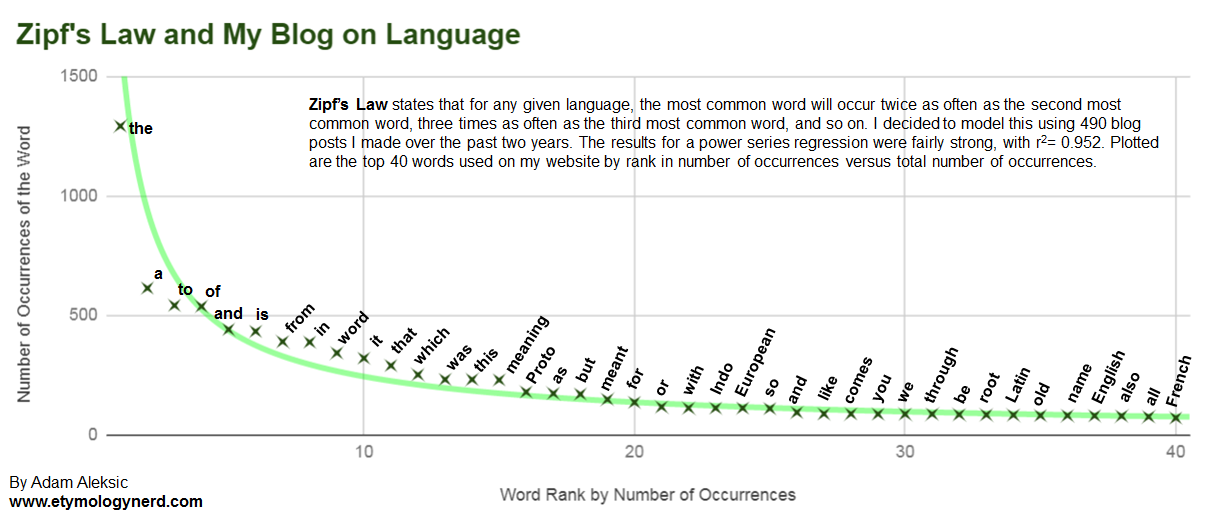
(Thanks to Adam at https://www.etymologynerd.com/)

## Visualizing word embeddings

So far we've only seen a shortened printout of word embeddings.
It might be useful to get a better idea of what we're transforming. So before we apply changes, let's take a closer look at some embeddings. We know each word vector/embedding is a column in W, characterized by w components running along its rows. Each component is a unique word in the vocabulary of the corpus populating this VSM, Gigaword. 
### Age 
In in the 'Age' we see the embeddings for age represented as an abstract column. The co-occurance between each component and the word embedding is a band. The large elements in W['age'], for example have the widest bands in the column. I've colored tagged the components to make the connection more evident.
For reference, the top five co-occurances in Age: '**the**', 'of', 'at', 'and', 'in'
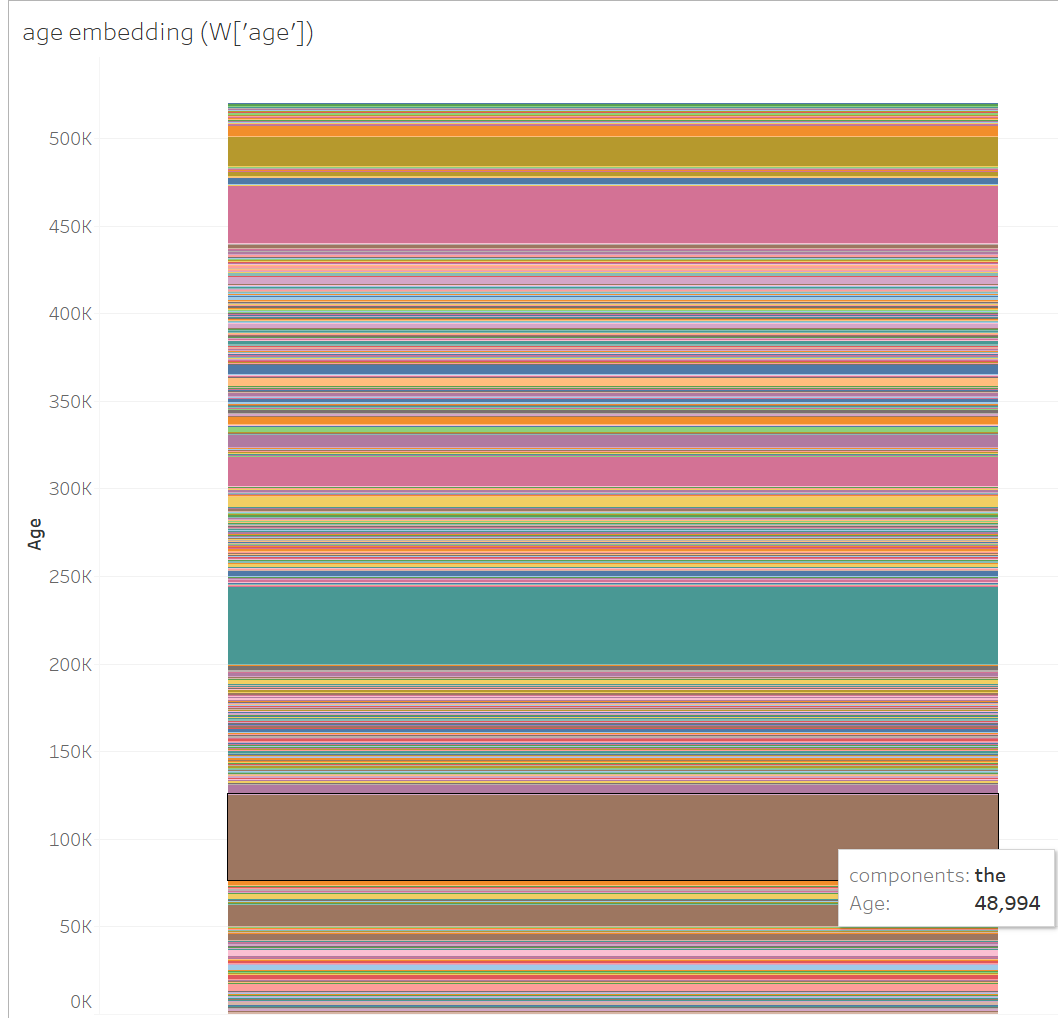

### Trio
##### Gallery link:  https://public.tableau.com/app/profile/jelan.samatar/viz/VisualizingWordEmbeddings/Trio
Since our VSM is comprised from a set of word vectors, the column space of W as a matrix is the equivalent to the embedding space of W as a VSM. So comparing word embeddings means making we want to make meaningful comparisons between columns. For example how does Age compare against Old and Clear. In the gallery, we see a visualization called 'Trio' of these three words. On first glance, Age and Old have a similar structure than Clear. However, all three tend to share the largest bands. Click the marker icon in the top right of the legend title 'components' to activate the highlight function. It lets you compare by component. Although this is a tiny glimpse of the space in W, exploring it gives a nice feel for how word embeddings relate to each other.Moreover it serves as a helpful, if incomplete, visual reference for where our VSM is. It paints a picture of latent knowledge obscured by noise.

## Quantitative Evaluation
Another way to judge our VSM is by seeing how it performs on relevant tasks. How well it does it mimic human judgement on how related a given pair of words is? A dataset formed by having folks sit down and score the relatedness between word pairs is called a relatedness dataset. I've used the dataset from Stanford's Linguistic/NLP department as our evaluative dataset (https://web.stanford.edu/class/cs224u/data/). 

In [5]:
DATA_HOME = os.path.join('data/data', 'wordrelatedness')
eval_df = pd.read_csv(
    os.path.join(DATA_HOME, "wordrelatedness-dev.csv"))

In [6]:
eval_df

,word1,word2,score
0,abandon,button,0.180000
1,abandon,consigning,0.400000
2,abandon,crane,0.160000
3,abandon,ditch,0.630000
4,abandon,left,0.570000
...,...,...,...
4751,wife,woman,0.728438
4752,withdraw,withdraw,1.000000
4753,workings,workings,1.000000
4754,workplace,workshop,0.767677


The basic idea is to use the word embeddings to predict a relatedness score. Then we'll compare the human rankings with our VSM's rankings through Spearman's $\rho$ value. For now, as a sanity check, let's see how a random guesser does. 

In [7]:
random_pred_df, random_score = vsm.word_relatedness_evaluation(eval_df, giga5, distfunc=random_scorer)
random_pred_df = distance2pred(random_pred_df)

In [10]:
print(f'SCORE: {random_score}')
random_pred_df.rename(columns={'score': 'relatedness score'})

SCORE: -0.00059854523902375


,word1,word2,relatedness score,prediction
0,abandon,button,0.180000,0.639427
1,abandon,consigning,0.400000,0.025011
2,abandon,crane,0.160000,0.275029
3,abandon,ditch,0.630000,0.223211
4,abandon,left,0.570000,0.736471
...,...,...,...,...
4751,wife,woman,0.728438,0.247392
4752,withdraw,withdraw,1.000000,0.529415
4753,workings,workings,1.000000,0.333570
4754,workplace,workshop,0.767677,0.393400


As we make transformations on our VSM, we'll see how it performs on evaluative tasks and explore what's in it with more visualizations. This work is continued in Page 2 of this project, called 'Statistical Methods'.